In [1]:
import os
import shutil
import unittest
from catvae.trainer import MultVAE, BiomDataModule
from catvae.sim import multinomial_bioms
from biom import Table
from biom.util import biom_open
import numpy as np
from pytorch_lightning import Trainer
import argparse
import seaborn as sns
import torch
torch.__version__

'1.8.0'

# Simulate data

In [2]:
np.random.seed(0)
k, D, N = 10, 50, 1000
sims = multinomial_bioms(k=k, D=D, N=N, M=50000)
Y = sims['Y']
parts = Y.shape[0] // 10
samp_ids = list(map(str, range(Y.shape[0])))
obs_ids = list(map(str, range(Y.shape[1])))
train = Table(Y[:parts * 8].T, obs_ids, samp_ids[:parts * 8])
test = Table(Y[parts * 8 : parts * 9].T,
             obs_ids, samp_ids[parts * 8 : parts * 9])
valid = Table(Y[parts * 9:].T, obs_ids, samp_ids[parts * 9:])
tree = sims
with biom_open('train.biom', 'w') as f:
    train.to_hdf5(f, 'train')
with biom_open('test.biom', 'w') as f:
    test.to_hdf5(f, 'test')
with biom_open('valid.biom', 'w') as f:
    valid.to_hdf5(f, 'valid')
    
sims['tree'].write('basis.nwk')

'basis.nwk'

# Train model

In [3]:

output_dir = 'output'
model = MultVAE(n_input=D, n_latent=k,
                n_hidden=16, basis='basis.nwk',
                dropout=0.5, bias=True, batch_norm=True,
                encoder_depth=1, learning_rate=0.1,
                scheduler='cosine', transform='pseudocount')
dm = BiomDataModule('train.biom', 'test.biom', 'valid.biom',
                    batch_size=50)

trainer = Trainer(
    max_epochs=50,
    gpus=1, 
    check_val_every_n_epoch=10,
)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type      | Params
-----------------------------------
0 | vae  | LinearVAE | 1.1 K 
-----------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/juermieboop/miniconda3/envs/catvae/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


In [4]:
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [5]:
trainer.model

MultVAE(
  (vae): LinearVAE(
    (encoder): Encoder(
      (encoder): Linear(in_features=49, out_features=10, bias=True)
    )
    (decoder): ParametrizedLinear(
      in_features=10, out_features=49, bias=True
      (parametrizations): ModuleDict(
        (weight): ParametrizationList(
          (0): Grassmannian(n=49, k=10, triv=matrix_exp)
        )
      )
    )
  )
)

# Evaluate the model

(0.9237995565809649, 0.0)


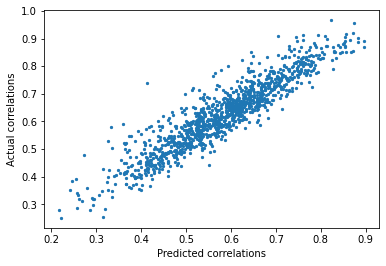

In [7]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist

W = model.vae.decoder.weight.detach().cpu().numpy()

d_estW = pdist(W)
simW = sims['W'] / np.sqrt(sims['eigs'])
dW = pdist(simW)

plt.scatter(dW, d_estW, s=5)
#plt.plot(np.linspace(0, 4), np.linspace(0, 4), 'r')
plt.xlabel('Predicted correlations')
plt.ylabel('Actual correlations')

print(pearsonr(dW, d_estW))